In [2]:
%load_ext autoreload
%autoreload 2

import random
import anaconfig
import os
import os.path as op

import numpy.typing as npt
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils.commonutils.crun import run_for_different_partitions
from utils.commonutils.config import (
    get_pipeline_config_path,cdirs, load_config, resolve_config_paths
)
from utils.commonutils.ctests import get_required_test_dataset_names
from utils.plotutils.plotconfig import configure_matplotlib
from scripts.evaluate import evaluate_partition

configure_matplotlib()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
partition = "minbias-sim10b-xdigi_v2.4_1498"
experiment_name = "scifi-3-xuvx"

config_path = get_pipeline_config_path(experiment_name)
config = load_config(config_path)
data_experiment_dir = op.join(
    cdirs.data_directory, config["common"]["experiment_name"]
)

In [8]:
from Processing.planewise_edges import get_planewise_edges

# Load one event
batch_dir = op.join(data_experiment_dir, "processed", "test", partition)
filenames = [file_.path for file_ in os.scandir(batch_dir) if file_.is_file and file_.name != "done"]
path = filenames[random.randint(0, len(filenames))]

batch = torch.load(path, map_location="cpu")


df_particles = pd.read_parquet(batch.truncated_path + "-particles.parquet", columns=["particle_id", "eta"])
df_particles["in_acceptance"] = (df_particles["eta"] > 2.0) & (df_particles["eta"] < 5.0)


In [9]:
# Dataframe of hits
df_hits = pd.DataFrame(
    {
        "hit_idx": np.arange(batch["x"].shape[0]),
        "plane": batch["plane"].numpy(),
        **{column: batch[column].numpy() for column in ["xatyeq0", "zatyeq0", "dxdy"]}
    }
)

df_hits_particles = pd.DataFrame(
    {
        "particle_id": batch["particle_id_hit_idx"][:, 0].numpy(),
        "hit_idx": batch["particle_id_hit_idx"][:, 1].numpy(),
    }
)
df_hits_particles = df_hits_particles.merge(
    df_particles,
    on="particle_id",
    how="left",
)
df_hits_particles = df_hits_particles.merge(
    df_hits,
    on="hit_idx",
)

In [10]:
def get_df_edges(
    edge_indices: npt.ArrayLike,
    df_hits: pd.DataFrame,
    **kwargs,
) -> pd.DataFrame:
    edge_indices = np.asarray(edge_indices)
    df_edges = pd.DataFrame(
        {
            "hit_idx_left": edge_indices[0],
            "hit_idx_right": edge_indices[1],
            **kwargs,
        },
    )

    # Add particle ID information
    for side in ["left", "right"]:
        df_edges = df_edges.merge(
            df_hits.rename(  # type: ignore
                columns={column: f"{column}_{side}" for column in df_hits.columns}
            ),
            on=f"hit_idx_{side}",
            how="left",
        )

    return df_edges

df_true_edges = get_df_edges(
    edge_indices=batch["signal_true_edges"].numpy(),
    df_hits=df_hits_particles,
)
df_true_edges = df_true_edges[df_true_edges["particle_id_left"] == df_true_edges["particle_id_right"]]
for column in ["particle_id", "in_acceptance", "eta"]:
    df_true_edges[column] = df_true_edges[f"{column}_left"]
    df_true_edges.drop([f"{column}_{side}" for side in ("left", "right")], axis=1, inplace=True)


In [11]:
x_planes = [0, 3, 4, 7, 8, 11]
df_true_edges = df_true_edges[df_true_edges["plane_left"].isin(x_planes) & df_true_edges["plane_right"].isin(x_planes)]


In [28]:
plane = 7
n_hits = 3

rng = np.random.default_rng()

df_true_edges_within_range = df_true_edges[
    (df_true_edges["plane_left"] == plane)
]

planes = np.concatenate(
    (
        [plane],
        df_true_edges_within_range["plane_right"].unique()
    )
)

df_hits_within_range = df_hits[df_hits["plane"].isin(planes)]


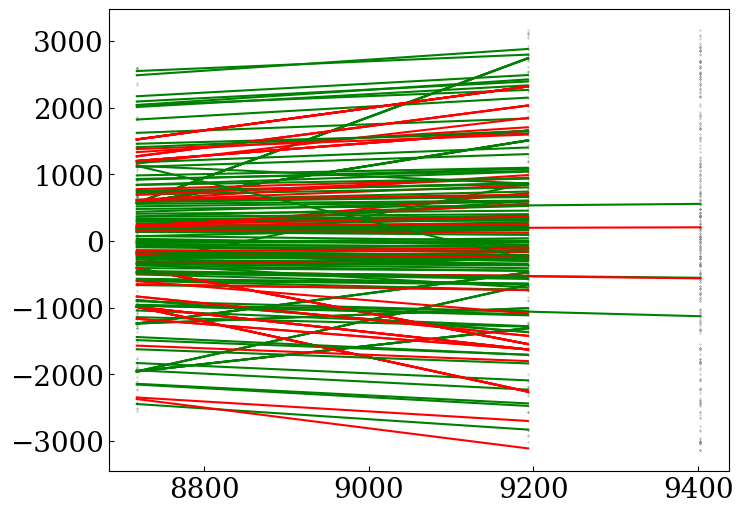

In [29]:
# Select `n_hits` random hits
hit_indices = df_true_edges_within_range["hit_idx_left"].unique()
# chosen_hit_indices = hit_indices[rng.integers(low=0, high=hit_indices.shape[0], size=(200,))]
chosen_hit_indices = hit_indices


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    df_hits_within_range["zatyeq0"],
    df_hits_within_range["xatyeq0"],
    color="grey",
    linestyle="",
    marker=".",
    markersize=0.5,
)

for _, edge in df_true_edges_within_range[df_true_edges_within_range["hit_idx_left"].isin(chosen_hit_indices)].iterrows():
    ax.plot(
        [edge["zatyeq0_left"], edge["zatyeq0_right"]],
        [edge["xatyeq0_left"], edge["xatyeq0_right"]],
        color="green" if edge["in_acceptance"] else "red",
    )


In [94]:
chosen_hit_indices

array([457, 527, 493, 429, 481, 503, 533, 502, 470, 466, 481, 513, 518,
       517, 542, 445, 514, 506, 533, 480])